# random forest model

CV for best feature combination

In [9]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps
import seaborn as sns

from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from itertools import chain, combinations

In [2]:
features = pd.read_csv('../jv-features.csv')
cc_features = pd.read_csv('../cc-features.csv')
features = features.merge(cc_features[['date','PctPNC','PctWP']], on='date')

features.sample(5)

,date,Weekday,OtherPuzAns,BlockDensity,AvgHintLength,AvgAnswerLength,NumHints,NumOneWordHints,PctOneWdHints,PctPerplex,WeekdayNum,NumRepeatedAnswers,CumTotalAnswers,NumRepeatedAnswers_Norm,PctPNC,PctWP
3097,2002-07-25,Thursday,53.000000,16.888889,16.222222,5.194444,72,10,13.888889,1.388889,3,63,60292,0.000015,20.833333,8.333333
5641,2009-09-20,Sunday,64.378571,18.140590,18.921429,5.157143,140,19,13.571429,7.142857,6,127,84113,0.000011,22.857143,6.428571
7848,2015-10-07,Wednesday,67.460526,17.777778,19.894737,4.868421,76,8,10.526316,11.842105,2,71,101867,0.000009,43.421053,9.210526
60,1994-03-02,Wednesday,79.423077,18.666667,15.243590,4.692308,78,15,19.230769,1.282051,2,27,4227,0.000082,25.641026,8.974359
6723,2012-09-06,Thursday,65.112500,15.625000,19.725000,5.150000,80,13,16.250000,5.000000,3,75,93104,0.000010,28.750000,3.750000


In [3]:
class_labels = features.groupby(['WeekdayNum','Weekday']).size().reset_index()['Weekday'].tolist()

In [4]:
def powerset(iterable):
    combos = []
    for i in range(1,len(iterable)+1):
        for c in combinations(iterable, i):
            combos.append(list(c))
    return combos

In [38]:
est = 500

## cross-validation for max depth

In [39]:
%%time

X = features[['BlockDensity', 'AvgAnswerLength', 'PctPerplex', 'PctOneWdHints', 'NumRepeatedAnswers_Norm', 'PctPNC', 'PctWP']].to_numpy()
y = features[['WeekdayNum']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)

kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
n = 20

accs = np.zeros((5,n))
precs = np.zeros((5,n))
recs = np.zeros((5,n))

for j in range(1,n+1):
    clear_output(wait=True)
    display(f"testing depth {j} (of {n})")
    rf = RandomForestClassifier(n_estimators = est, max_depth=j, random_state=617, verbose=1)
    i=0
    for train_index, test_index in kfold.split(X_train, y_train):
        X_train_train, X_train_test = X_train[train_index], X_train[test_index]
        y_train_train, y_train_test = y_train[train_index], y_train[test_index]
        
        rf_clone = clone(rf)
        rf_clone.fit(X_train_train,y_train_train.ravel())
        
        y_predict = rf_clone.predict(X_train_test)
        accs[i,j-1] = accuracy_score(y_train_test,y_predict)
        precs[i,j-1] = precision_score(y_train_test,y_predict,average='weighted',zero_division=0)
        recs[i,j-1] = recall_score(y_train_test,y_predict,average='weighted',zero_division=0)
        i = i + 1

'testing depth 20 (of 20)'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

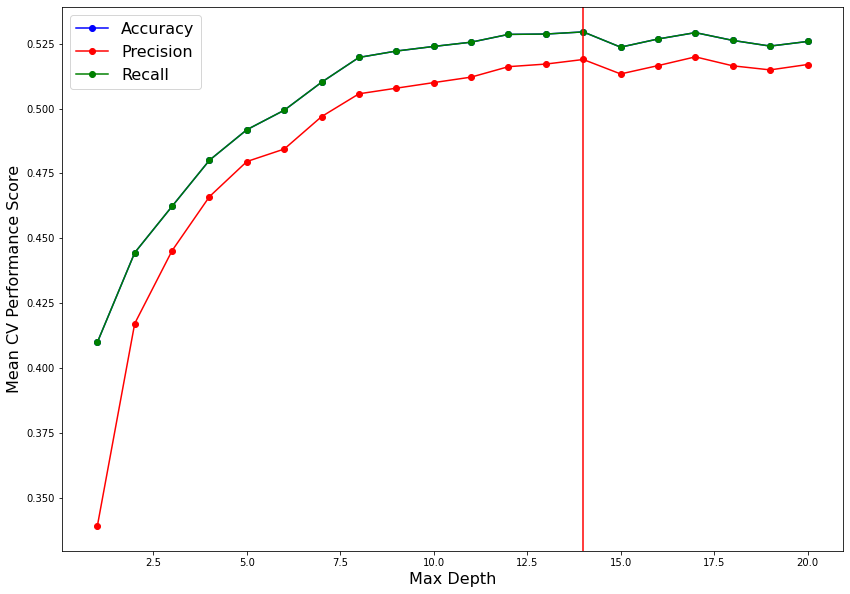

In [40]:
best_depth = np.argmax(np.mean(accs, axis=0))+1
plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")
plt.axvline(x=best_depth, color='r')
#plt.annotate("best depth",(best_k+1,37.3), fontsize=14)
plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [41]:
print(f"The highest accuraccy is in the model with a max depth of {best_depth}.")

The highest accuraccy is in the model with a max depth of 14.


## CV for feature selection

In [42]:
%%time

feature_list = ['BlockDensity','OtherPuzAns','AvgAnswerLength','PctPerplex','PctOneWdHints','NumRepeatedAnswers_Norm', 'PctPNC','PctWP']
feature_combos = powerset(feature_list)


accs = np.zeros((5,len(feature_combos)))
precs = np.zeros((5,len(feature_combos)))
recs = np.zeros((5,len(feature_combos)))

for j, combo in enumerate(feature_combos):
    X = features[combo].to_numpy()
    y = features[['WeekdayNum']].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)
    kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
    
    clear_output(wait=True)
    display(f"testing subset {j+1} (of {len(feature_combos)})")
    
    rf = RandomForestClassifier(n_estimators = est, max_depth=14, random_state=617,verbose=1)
    i=0
    for train_index, test_index in kfold.split(X_train, y_train):
        X_train_train, X_train_test = X_train[train_index], X_train[test_index]
        y_train_train, y_train_test = y_train[train_index], y_train[test_index]
        
        rf_clone = clone(rf)
        rf_clone.fit(X_train_train,y_train_train.ravel())
        
        y_predict = rf_clone.predict(X_train_test)
        accs[i,j] = accuracy_score(y_train_test,y_predict)
        precs[i,j] = precision_score(y_train_test,y_predict,average='weighted',zero_division=0)
        recs[i,j] = recall_score(y_train_test,y_predict,average='weighted',zero_division=0)
        i = i + 1

'testing subset 61 (of 255)'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

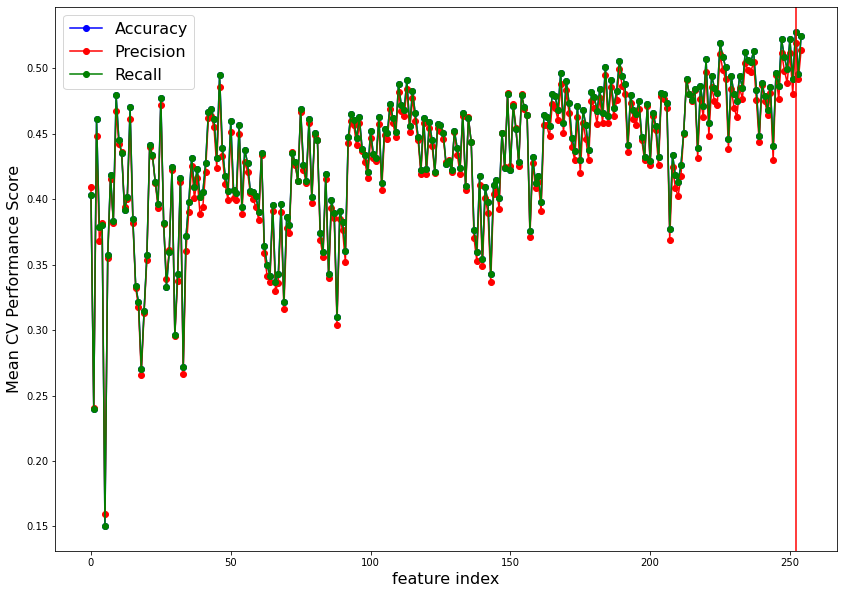

In [34]:
best_features = np.argmax(np.mean(accs, axis=0))
plt.figure(figsize=(14,10))

plt.plot(range(len(feature_combos)), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(len(feature_combos)), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(len(feature_combos)), np.mean(recs,axis=0),'g-o', label="Recall")
plt.axvline(x=best_features, color='r')
#plt.annotate("best depth",(best_k+1,37.3), fontsize=14)
plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("feature index",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [22]:
print(f"The highest accuraccy is in the model the features {feature_combos[best_features]}.")

The highest accuraccy is in the model the features ['BlockDensity', 'OtherPuzAns', 'AvgAnswerLength', 'PctOneWdHints', 'NumRepeatedAnswers_Norm', 'PctPNC', 'PctWP'].


## details on best model

In [43]:
est = 200
dep = 17
feat = ['BlockDensity', 
          'OtherPuzAns', 
          'AvgAnswerLength', 
          'PctOneWdHints', 
          'NumRepeatedAnswers_Norm', 
          'PctPNC', 
          'PctWP']

In [51]:
X = features[feat].to_numpy()
#X = features[feature_combos[best_features]].to_numpy()

y = features[['WeekdayNum']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)

rf_f = RandomForestClassifier(n_estimators = est, max_depth=dep)
rf_f.fit(X_train,y_train.ravel())

RandomForestClassifier(max_depth=17, n_estimators=200)

In [52]:
y_pred = rf_f.predict(X_test)
f_acc = accuracy_score(y_test,y_pred)
f_prec = precision_score(y_test,y_pred,average='micro')
f_rec = recall_score(y_test,y_pred,average='micro')
print(f"Overall scores:")
print(f"Accuracy:\t{np.round(f_acc*100,2)}%")
print(f"Precision:\t{np.round(f_prec*100,2)}%")
print(f"Recall:\t\t{np.round(f_rec*100,2)}%")

Overall scores:
Accuracy:	52.54%
Precision:	52.54%
Recall:		52.54%


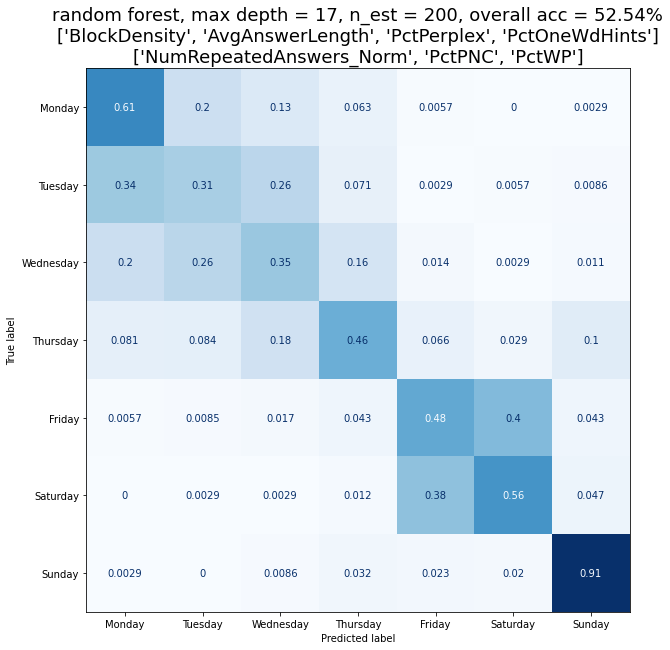

features: ['BlockDensity', 'AvgAnswerLength', 'PctPerplex', 'PctOneWdHints', 'NumRepeatedAnswers_Norm', 'PctPNC', 'PctWP']


In [54]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(rf_f, X_test, y_test, 
                      display_labels=class_labels,
                      ax=ax, 
                      normalize='true',
                      cmap=cm.get_cmap('Blues'),
                      colorbar=False)
ax.set_title(f"random forest, max depth = {dep}, n_est = {est}, overall acc = {np.round(f_acc*100,2)}%\n{feature_combos[best_features][:4]}\n{feature_combos[best_features][4:]}", fontsize=18)
plt.savefig("RandomForestCVfeat.png")
plt.show()
print("features:",feature_combos[best_features])